## Dataset

**Data fields:**
    
- **Patient_ID** - The unique identifier of the patient
- **Family_Case_ID** - The family identification
- **Severity** - The severity of the disease, where 1 is the lowest and 3 the highest severity
- **Name** - The name of the patient
- **Birthday_year** - The year of birthday of the patient
- **Parents_Siblings_Infected** - The number of parents and/or siblings infected
- **Partner_Children_Infected** - The number of partner and/or children infected
- **Medical_Expenses_Family** - The medical expenses associated to try to contain the epidemy on the family
- **Medical_Tent** - The medical tent where the patient is / was lodged
- **City** - The original city of the patient
- **Deceased** - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

## Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb
import math
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder


## Functions

In [2]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test), str(avg_iter) + '+/-' + str(std_iter)

In [3]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_iter = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_iter
        count+=1
    return df

In [4]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sb.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [5]:
def plt_box(data):
    n_col = 2
    n_row = 2
    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 10))
    for var, subplot in zip(data[numerical], ax.flatten()):
        sb.boxplot(data[var], ax=subplot)

In [6]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

 ## Data exploration

### Full dataset exploration

preprocess as types 
year as integer 
patient_id and Family case as text

In [7]:
Pandemic = pd.read_csv(r'C:/Users/Sasha/Documents/NOVA MAA/Machine learning/Project/train.csv')
Pandemic.describe(include='all')

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


In [8]:
# Check missing values
print(Pandemic.isnull().sum())

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64


**Initial considerations:**

We have 900 patients records
* one patient name repeats once but looking at the patients info we conclude these are two different people with same names
* Families can be tracked by Family_case_ID
* Birthday Year not available for everyone - fill in with KNNFiller? Also easier to work with age so will create a column "Age"(as of January 1st, 2020 when epidemic started)
* City has two missing values - fill in with KNNFiller?
* Medical tent can be unknown? (are there patients without tent or its data collection error?) so we cannot realy extrapolate these values and there are too many patients without Tent (almost 80%)
* Medical tent has many categories (8). This can indicate an issue with distribution
* target value (deceased or not) is evenly distributed



In [9]:
# Exploration of categorical variables: cross table of Tents and city and severity of infection
table1 = pd.crosstab(index=Pandemic['City'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
City,,,
Albuquerque,85,17,67
Santa Fe,127,165,357
Taos,2,4,74


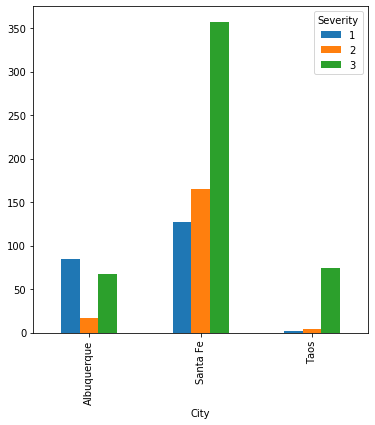

In [10]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=False)

In [11]:
table1 = pd.crosstab(index=Pandemic['Medical_Tent'], columns=Pandemic['Severity'])
table1

Severity,1,2,3
Medical_Tent,,,
A,15,0,0
B,46,0,0
C,56,0,1
D,27,4,0
E,24,4,3
F,0,8,5
G,0,0,4
T,1,0,0


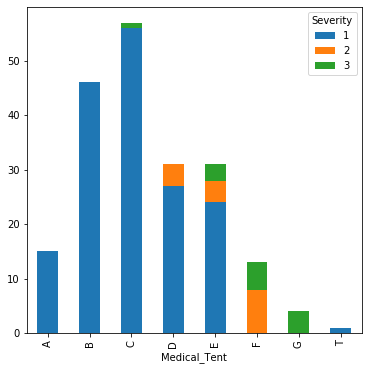

In [12]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

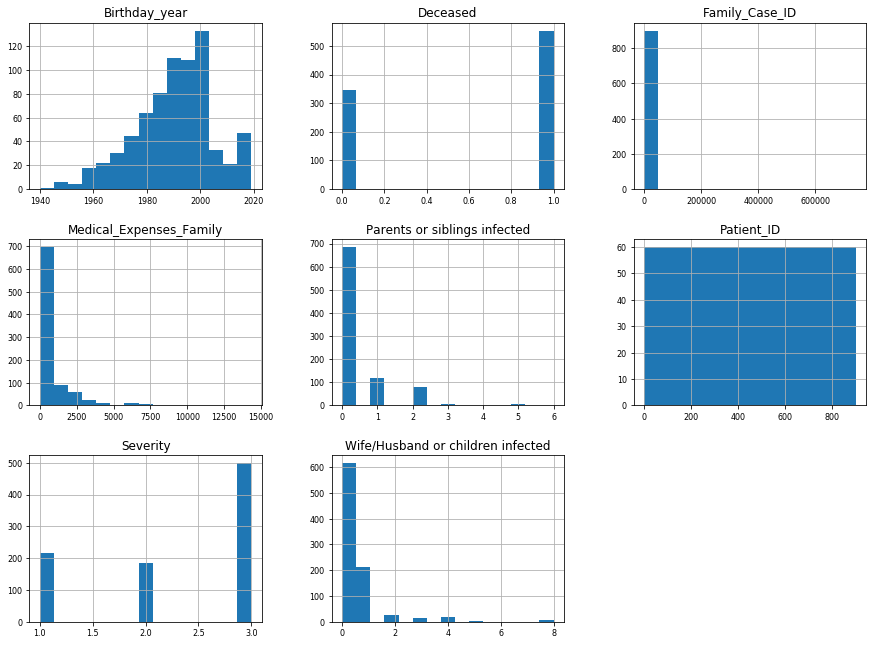

In [13]:
# Do histograms on all numeric variables
numerical=Pandemic.select_dtypes(include=[np.number]).columns.tolist()
Pandemic[numerical].hist(bins=15, figsize=(15, 15), layout=(4, 3), xlabelsize=8, ylabelsize=8);

Age has somewhat normal distribution, but Medical expenses need to be transformed. Also Infected family needs to be looked at.

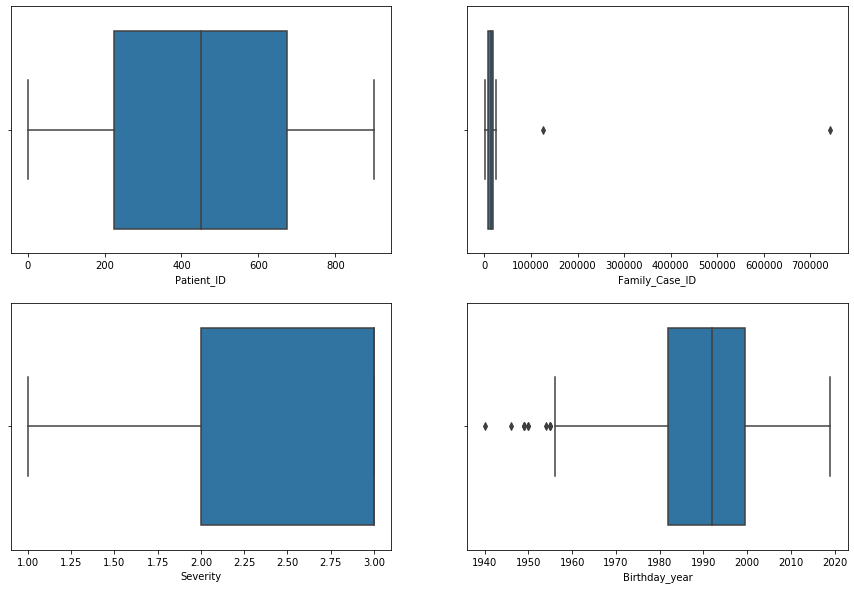

In [14]:
# Boxplots on all numeric variables
plt_box(Pandemic[numerical])

### Exploration of variables in relation to target

In [15]:
#average metrics for Deceased and Survivors to get initial insights
Pandemic.groupby('Deceased').mean()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family
Deceased,,,,,,,
0,449.423631,13619.536023,1.962536,1991.698305,0.463977,0.475504,1340.755043
1,451.175407,14736.466546,2.533454,1989.280374,0.327306,0.549729,616.504521


In [16]:
#Exploring categorical features
piv1=pd.pivot_table(Pandemic, values='Patient_ID', index=['City'], columns=['Deceased'],aggfunc='count')
piv2=pd.pivot_table(Pandemic, values='Patient_ID', index=['Severity'], columns=['Deceased'],aggfunc='count')
piv3=pd.pivot_table(Pandemic, values='Patient_ID', index=['Medical_Tent'], columns=['Deceased'],aggfunc='count')

display_side_by_side(piv1,piv2,piv3)


Deceased,0,1
City,,
Albuquerque,94,75
Santa Fe,221,428
Taos,30,50
Deceased,0,1
Severity,,
1,136,80
2,88,98
3,123,375
Deceased,0,1


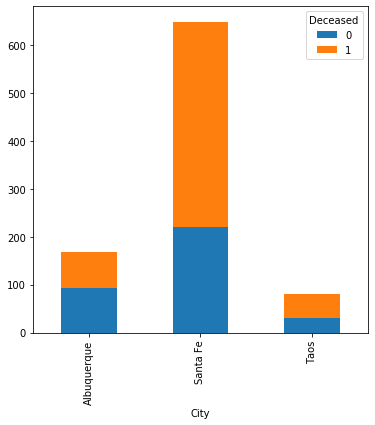

In [17]:
piv1.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

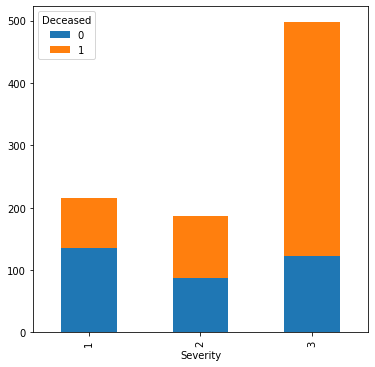

In [18]:
piv2.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

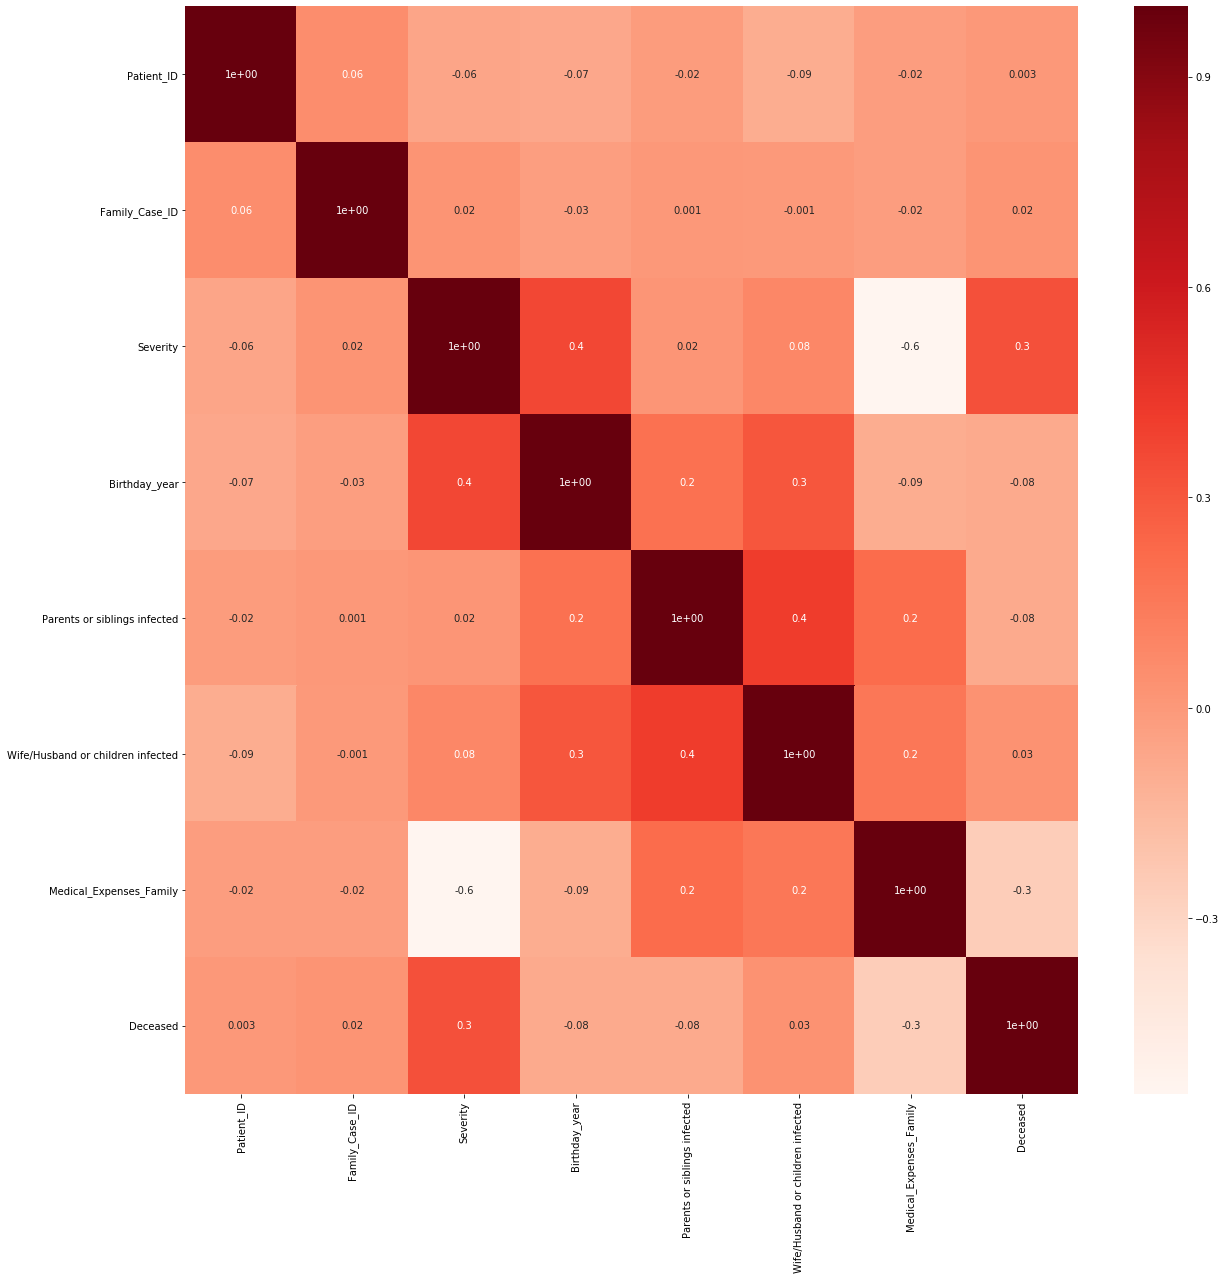

In [19]:
corr_df = Pandemic.corr()
cor_heatmap(corr_df)

In [20]:
abs(corr_df['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.333286
Medical_Expenses_Family              0.254510
Parents or siblings infected         0.082862
Birthday_year                        0.081879
Wife/Husband or children infected    0.032909
Family_Case_ID                       0.021400
Patient_ID                           0.003282
Name: Deceased, dtype: float64

**Some conclusions relating to target variable and input features**

* Family infected - younger patients die less, lower average in "Parents or siblings infected" can be explained by this. Also the two variables for infected in family seem to relay similar info so potentially can be merged into one feature "Family members infected" which reflects sum of the two columns
* Discard of "Medical_Tent" as almost 80% records do not have it or replace nulls with 9th category "No Tent"
* Create age variable
* Santa Fe has worst situation for severity of disease and number of infected, Albuquerque is next in number of infected but still has more people with lighter form of illness than the severe
* Survivors have spent more on medical expenses
* Severity, Medical expenses and Birthday Year are highly correlated.
* Partners/kids and parents/siblings are correlated

 **Severity, Medical expenses and infected family are most important features for the outcome of the illness**


## Pre-Processing

In [21]:
# Dealing with missing values
#dropping missing city
Pandemic.dropna(subset=['City'],axis=0,inplace=True)

#filling the missing Medical tent with "None"
Pandemic['Medical_Tent'].fillna('None',inplace=True)

#dropping the missing birthday (try KNNImputer too)
Pandemic.dropna(subset=['Birthday_year'],axis=0,inplace=True)

In [22]:
#create new variables age and Family infected 
Pandemic['Age']=2020-Pandemic['Birthday_year']
Pandemic.drop(['Birthday_year'],axis=1,inplace=True)

#create new variable Family_infected
#Pandemic['Family_infected']=Pandemic['Parents or siblings infected']+Pandemic['Wife/Husband or children infected']
#Pandemic.drop(['Parents or siblings infected','Wife/Husband or children infected'],axis=1,inplace=True)


In [23]:
#log tranformation for Expenses
#Pandemic['Log_expenses'] = np.log1p(Pandemic['Medical_Expenses_Family'])
#Pandemic.drop(['Medical_Expenses_Family'],axis=1,inplace=True)

In [24]:
#replacing missing age with predictions
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=3)
#imputer.fit(Pandemic)
#filled_data = imputer.transform(Pandemic)

In [25]:
#maybe bin age

#### Encoding categorical

In [26]:
# Encode categorical variables to dummy variables
import category_encoders as ce
encode = ['City', 'Medical_Tent']
ce_one_hot = ce.OneHotEncoder(cols = encode, use_cat_names=True)
encoded = ce_one_hot.fit_transform(Pandemic[encode])

complete = pd.concat([Pandemic, encoded], axis=1)
complete.drop(encode,axis=1,inplace=True)

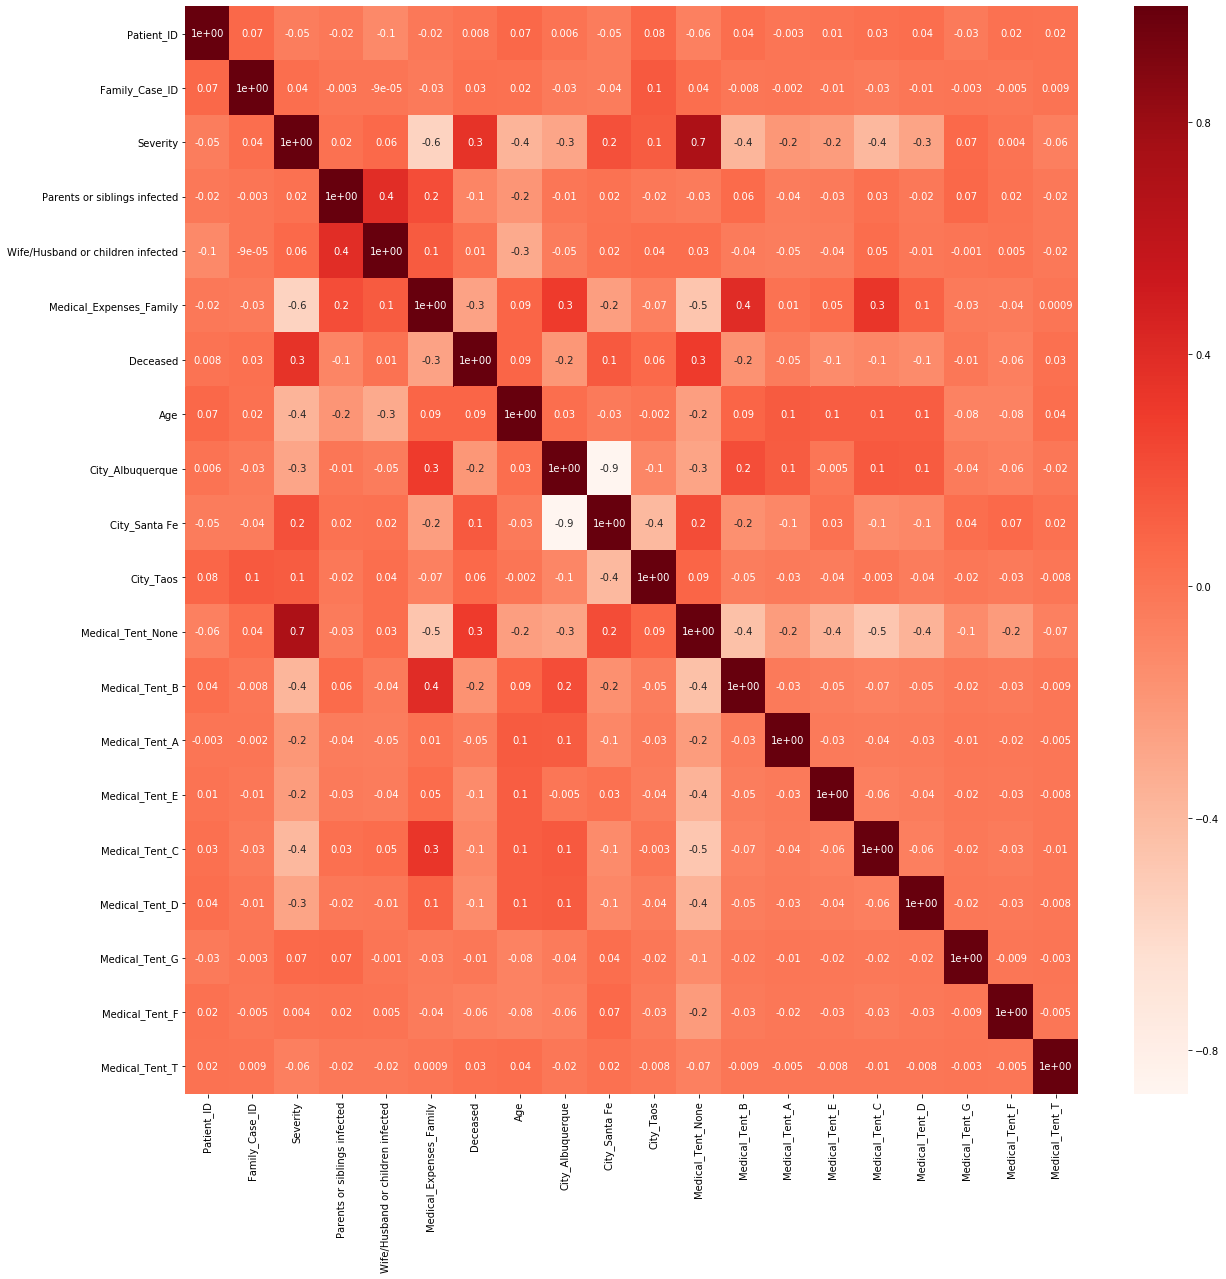

In [27]:
cor_heatmap(complete.corr())

In [28]:
abs(complete.corr()['Deceased']).sort_values(ascending=False)

Deceased                             1.000000
Severity                             0.349692
Medical_Tent_None                    0.302286
Medical_Expenses_Family              0.262713
City_Albuquerque                     0.196007
Medical_Tent_B                       0.167971
City_Santa Fe                        0.149973
Medical_Tent_D                       0.132441
Medical_Tent_E                       0.132441
Medical_Tent_C                       0.101961
Parents or siblings infected         0.096437
Age                                  0.087038
City_Taos                            0.064006
Medical_Tent_F                       0.058283
Medical_Tent_A                       0.046871
Medical_Tent_T                       0.030835
Family_Case_ID                       0.026460
Medical_Tent_G                       0.014237
Wife/Husband or children infected    0.012059
Patient_ID                           0.007536
Name: Deceased, dtype: float64

## Feature engineering

In [29]:
todrop=['Patient_ID','Family_Case_ID', 'Name',
       'Medical_Tent_A', 'Medical_Tent_None',
       'Medical_Tent_G', 'Medical_Tent_F', 'Medical_Tent_T','Wife/Husband or children infected']

In [30]:
#drop variables based on low correlations with target and high mutual correlations
complete.drop(todrop,axis=1,inplace=True)

In [31]:
complete.columns

Index(['Severity', 'Parents or siblings infected', 'Medical_Expenses_Family',
       'Deceased', 'Age', 'City_Albuquerque', 'City_Santa Fe', 'City_Taos',
       'Medical_Tent_B', 'Medical_Tent_E', 'Medical_Tent_C', 'Medical_Tent_D'],
      dtype='object')

In [32]:
complete.head()

,Severity,Parents or siblings infected,Medical_Expenses_Family,Deceased,Age,City_Albuquerque,City_Santa Fe,City_Taos,Medical_Tent_B,Medical_Tent_E,Medical_Tent_C,Medical_Tent_D
1,1,0,1663,0,54.0,1,0,0,0,0,0,0
2,3,0,221,1,38.0,0,1,0,0,0,0,0
3,3,0,220,1,23.0,0,1,0,0,0,0,0
4,3,0,222,0,26.0,0,1,0,0,0,0,0
6,3,0,435,1,36.0,0,1,0,0,0,0,0


## Train and Validation Normalized

In [33]:
#Split into data and target: X contains independent variables (before scaling) and y contains target
X = complete.drop(['Deceased'], axis=1)
y = complete['Deceased']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.3, 
                                                    random_state = 150,
                                                    shuffle = True, 
                                                    stratify = y)

In [35]:
# Normalize all independent variables and create scaler based on train set. X_train = scaled training set, X_test = scaled test set
X_train_array = X_train.values # returns a numpy array
X_test_array = X_test.values
min_max_scaler = MinMaxScaler()
X_train_scaler = min_max_scaler.fit(X_train_array)
X_train_scaled = X_train_scaler.transform(X_train_array)
X_test_scaled = X_train_scaler.transform(X_test_array)
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

## Classifier

### 1. Multi-Layer Perceptron with default settings = Baseline

Default for MLPClassifier
parameter_space = {
    'hidden_layer_sizes': (100,),
    'activation': 'relu',
    'solver': 'adam',
    'learning_rate_init': 0.001,
    'learning_rate': 'constant',
    'alpha': 0.0001
    'batch_size':200,
    'max_iter':200,
    'shuffle':True
    'random_state':None,
    'tol':1e-4.
    'momentum':0.9 (between 0 and 1),
    'early_stopping':False,
    'validation_fraction': 0.1(for early_stopping)
}

In [36]:
from sklearn.neural_network import MLPClassifier

In [37]:
model = MLPClassifier(random_state=150)

In [38]:
df = pd.DataFrame(columns = ['Time','Train','Test', 'Iterations'], index = ['Baseline'])
show_results(df, model)

,Time,Train,Test,Iterations
Baseline,0.26+/-0.03,0.645+/-0.04,0.634+/-0.04,51.6+/-5.7
